In [2]:
import models
import datasets
import loss_functions
import networks

import numpy as np
import random
import os
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
from numpy.linalg import norm
def euclidean_disance(x, y):
    return norm(x - y)


def most_common(arr):
    counts = np.bincount(arr)
    return np.argmax(counts)

In [4]:
def predict_label(encoding, encodings, labels, k):
    distances = np.zeros(len(encodings))
    for indx, x in enumerate(encodings, 0):
        distance = euclidean_disance(encoding, x)
        distances[indx] = distance

    zipped = list(zip(encodings, distances, labels))
    zipped.sort(key=lambda t: t[1])
    zipped = zipped[1:k + 1]
    labels = np.array(zipped)[:, 2].astype(int)
    result = most_common(labels)
    return result

In [5]:
def plot_results(encodings, labels):
    color = ['blue' if label == 0 else 'red' for label in labels]
    plt.scatter(encodings[:, 0], encodings[:, 1], c=color)
    plt.show()

In [6]:
def print_scores(labels, predicted_labels):
    print("Accuracy: {}".format(accuracy_score(labels, predicted_labels)))
    print("Precision: {}".format(precision_score(labels, predicted_labels)))
    print("Recall: {}".format(recall_score(labels, predicted_labels)))
    print("F1: {}".format(f1_score(labels, predicted_labels)))

In [7]:
def plot_loss(loss_history):
    plt.plot(loss_history)
    plt.show()

In [8]:
def undersample(images):
    false_images = []
    true_images = []
    for image in images:
        false_images.append(image) if image.__contains__("False") else true_images.append(image)

    false_images = false_images[0:len(true_images)]
    images = false_images
    images.extend(true_images)
    return images

In [9]:
def eval_model(model, dataloader_train, dataloader_test):
    encodings, labels = model.predict(dataloader_train)
    plot_results(encodings, labels)
    
    encodings, labels = model.predict(dataloader_test)
    plot_results(encodings, labels)
    
    predicted_labels = []
    for encoding, label in (zip(encodings, labels)):
        predicted_labels.append(predict_label(encoding, encodings, labels, 3))

    predicted_labels = np.array(predicted_labels)
    print_scores(labels, predicted_labels)

# T2

In [18]:
path = './Data/t2_tra_np_min_max'
images = os.listdir(path)
random.shuffle(images)

In [19]:
train, test = train_test_split(images, test_size=0.3)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=128, drop_last=True)

In [20]:

model = models.SiameseModel(2, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)


Epoch no. 0
Batch 2699
Current loss 0.06638221442699432

Epoch no. 1
Batch 2699
Current loss 0.011621572077274323



In [12]:
plot_loss(loss_history)

NameError: name 'loss_history' is not defined

In [21]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)

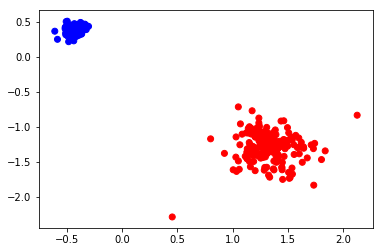

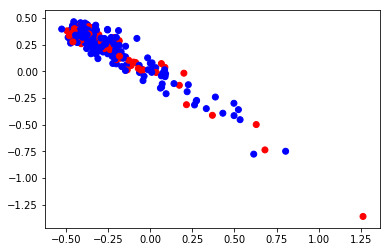

Accuracy: 0.6694677871148459
Precision: 0.22
Recall: 0.12222222222222222
F1: 0.15714285714285714


In [22]:
eval_model(model, dataloader_train_eval, dataloader_test_eval)

# Diff

In [23]:
path = './Data/diff_ADC_BVAL_np_min_max'
images = os.listdir(path)
random.shuffle(images)

In [24]:
train, test = train_test_split(images, test_size=0.3)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=64, drop_last=True)


In [25]:
%%capture

model = models.SiameseModel(1, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)


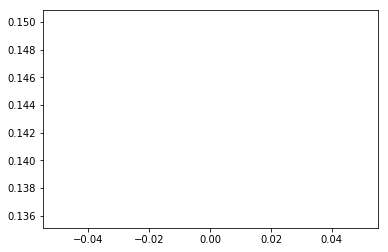

In [26]:
plot_loss(loss_history)

In [27]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)

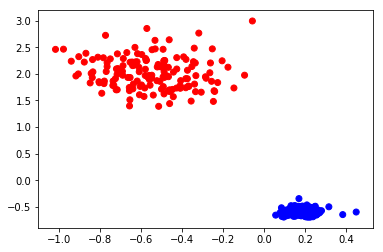

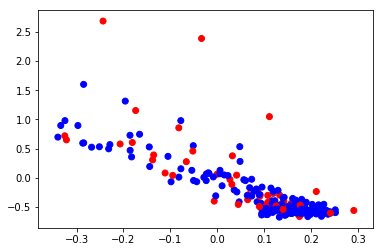

Accuracy: 0.7173144876325088
Precision: 0.18181818181818182
Recall: 0.1016949152542373
F1: 0.13043478260869565


In [28]:
eval_model(model, dataloader_train_eval, dataloader_test_eval)

# T2 3D

In [29]:
path = './Data/t2_tra_np_3D_min_max'
images = os.listdir(path)
random.shuffle(images)

In [31]:
train, test = train_test_split(images, test_size=0.3)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=64, drop_last=True)


In [32]:
%%capture

model = models.SiameseModel(1, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)


KeyboardInterrupt: 

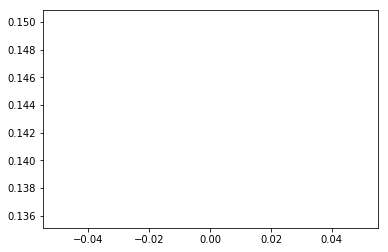

In [33]:
plot_loss(loss_history)

In [34]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)

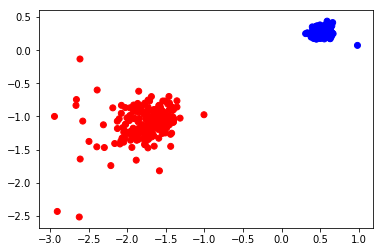

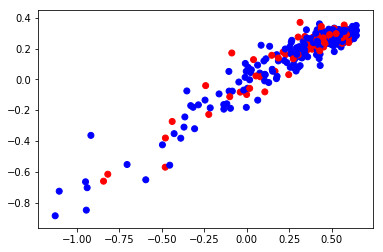

Accuracy: 0.6890756302521008
Precision: 0.10256410256410256
Recall: 0.05
F1: 0.06722689075630252


In [35]:
eval_model(model, dataloader_train_eval, dataloader_test_eval)

# Diff 3D

In [135]:
path = './Data/diff_ADC_BVAL_3D_np_min_max'
images = os.listdir(path)
random.shuffle(images)

In [136]:
train, test = train_test_split(images, test_size=0.2)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=64, drop_last=True)


In [137]:
%%capture

model = models.SiameseModel(1, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)


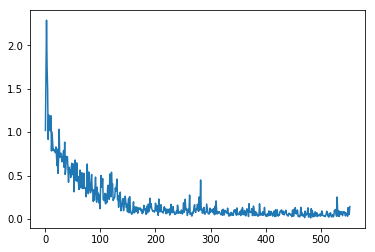

In [138]:
plot_loss(loss_history)

In [139]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)

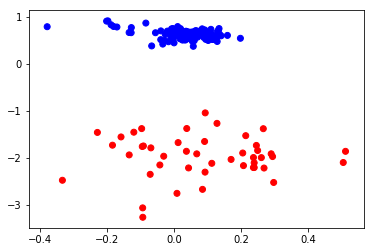

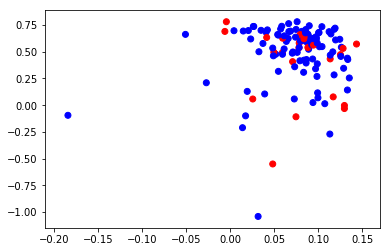

Accuracy: 0.7142857142857143
Precision: 0.0
Recall: 0.0
F1: 0.0


In [140]:
eval_model(model, dataloader_train_eval, dataloader_test_eval)

# T2 Undersample

In [141]:
path = './Data/t2_tra_np_min_max'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)


In [142]:
train, test = train_test_split(images, test_size=0.2)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=64, drop_last=True)


In [143]:
%%capture

model = models.SiameseModel(2, 0.0001, networks.SiameseNet(networks.Net2DChannel1()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)


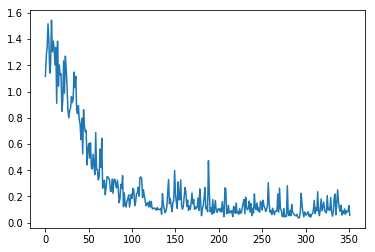

In [144]:
plot_loss(loss_history)

In [145]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)

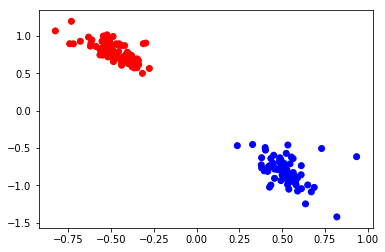

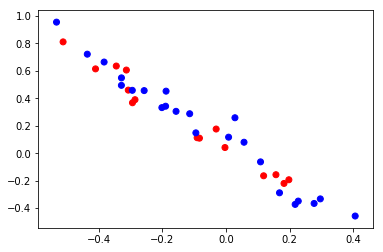

Accuracy: 0.6578947368421053
Precision: 0.5625
Recall: 0.6
F1: 0.5806451612903225


In [146]:
eval_model(model, dataloader_train_eval, dataloader_test_eval)

# Diff Undersample

In [10]:
path = './Data/diff_ADC_BVAL_np_min_max'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)

In [11]:
train, test = train_test_split(images, test_size=0.2)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=64, drop_last=True)


In [12]:
%%capture
model = models.SiameseModel(2, 0.0001, networks.SiameseNet(networks.Net2DChannel2()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)


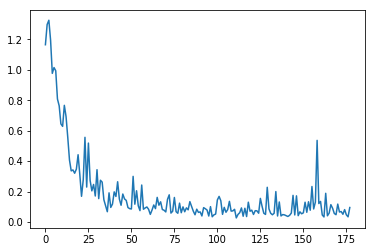

In [13]:
plot_loss(loss_history)

In [14]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)

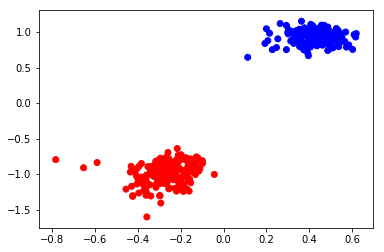

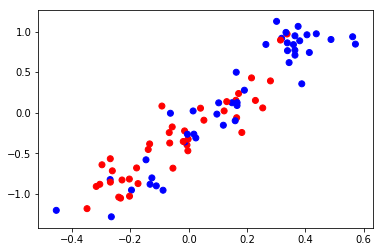

Accuracy: 0.5952380952380952
Precision: 0.5833333333333334
Recall: 0.525
F1: 0.5526315789473685


In [15]:
eval_model(model, dataloader_train_eval, dataloader_test_eval)

# T2 3D Undersample

In [ ]:
path = './Data/t2_tra_np_3D_min_max'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)

In [ ]:
train, test = train_test_split(images, test_size=0.2)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=64, drop_last=True)

In [155]:
%%capture

model = models.SiameseModel(2, 0.0001, networks.SiameseNet(networks.Net3DChannel1()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)

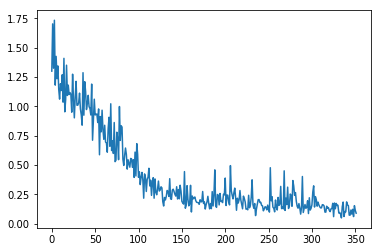

In [156]:
plot_loss(loss_history)

In [157]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)

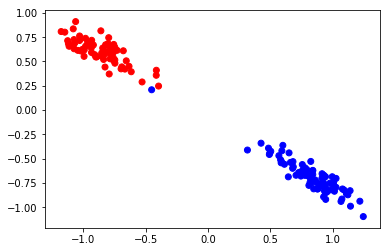

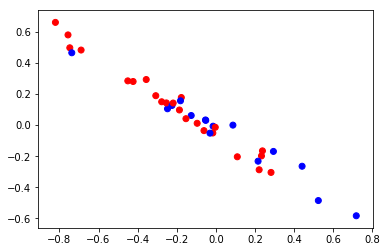

Accuracy: 0.47368421052631576
Precision: 0.56
Recall: 0.6086956521739131
F1: 0.5833333333333334


In [158]:
eval_model(model, dataloader_train_eval, dataloader_test_eval)

# Diff 3D Undersample

In [159]:
path = './Data/diff_ADC_BVAL_3D_np_min_max'
images = os.listdir(path)
images = undersample(images)
random.shuffle(images)

In [160]:
train, test = train_test_split(images, test_size=0.2)
dataset_train = datasets.SiameseDataset(path, train)
dataset_test = datasets.SiameseDataset(path, test)
dataloader_train = DataLoader(dataset_train, shuffle=1, num_workers=4, batch_size=64, drop_last=True)


In [161]:
%%capture

model = models.SiameseModel(1, 0.0001, networks.SiameseNet(networks.Net3DChannel2()).cuda(), loss_functions.ContrastiveLoss())
loss_history = model.fit(dataloader_train)


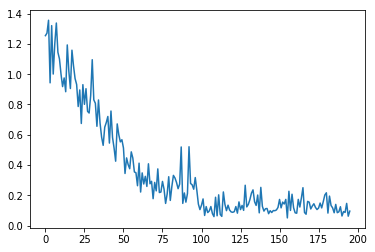

In [162]:
plot_loss(loss_history)

In [163]:
dataloader_train_eval = DataLoader(dataset_train.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)
dataloader_test_eval = DataLoader(dataset_test.change_strategy(get_pair=False), shuffle=0, num_workers=4, batch_size=64, drop_last=False)

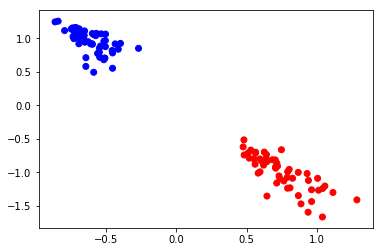

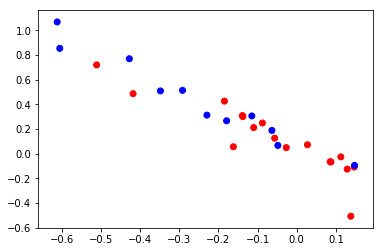

Accuracy: 0.4642857142857143
Precision: 0.5555555555555556
Recall: 0.5882352941176471
F1: 0.5714285714285715


In [164]:
eval_model(model, dataloader_train_eval, dataloader_test_eval)